In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tf_hub

TensorFlow 2.x selected.


In [0]:
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from matplotlib import style
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import logging
import math
import numpy as np
import os
import pandas as pd
import urllib3

In [0]:
logger = tf.get_logger()

In [0]:
logger.setLevel(level=logging.ERROR)
style.use(style='ggplot')
tfds.disable_progress_bar()
urllib3.disable_warnings(category=urllib3.exceptions.InsecureRequestWarning)

In [46]:
splitting = tfds.Split.ALL.subsplit(weighted=(75, 15, 10))
splitting

(NamedSplitAll()(tfds.percent[0:75]),
 NamedSplitAll()(tfds.percent[75:90]),
 NamedSplitAll()(tfds.percent[90:100]))

In [0]:
dataset_cifar10, cifar10_info = tfds.load(name='cifar10', 
                                          split=splitting, 
                                          as_supervised=True, 
                                          with_info=True)

In [0]:
train_dataset, valid_dataset, test_dataset = dataset_cifar10

In [49]:
class_num = cifar10_info.features['label'].num_classes

num_training_examples   = 0
num_validation_examples = 0
num_testing_examples    = 0

for example_train in train_dataset:
  num_training_examples += 1

for example_valid in valid_dataset:
  num_validation_examples += 1

for example_test in test_dataset:
  num_testing_examples += 1

class_names = np.array(cifar10_info.features['label'].names)

for i, class_ in enumerate(class_names):
  print(f"{i}  -->  {class_}")

print(f"\nTraining examples   : {num_training_examples}")
print(f"Validation examples : {num_validation_examples}")
print(f"Testing examples    : {num_testing_examples}")

0  -->  airplane
1  -->  automobile
2  -->  bird
3  -->  cat
4  -->  deer
5  -->  dog
6  -->  frog
7  -->  horse
8  -->  ship
9  -->  truck

Training examples   : 45000
Validation examples : 9000
Testing examples    : 6000


In [0]:
def normalize_images_labels(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

In [0]:
BATCH_SIZE = 20
IMG_SIZE = 32

In [0]:
train_dataset = train_dataset.map(map_func=normalize_images_labels)
train_dataset = train_dataset.shuffle(buffer_size=num_training_examples//8)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=1)

In [0]:
valid_dataset = valid_dataset.map(map_func=normalize_images_labels)
valid_dataset = valid_dataset.batch(batch_size=BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(buffer_size=1)

In [0]:
test_dataset = test_dataset.map(map_func=normalize_images_labels)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE)

In [0]:
train_dataset = train_dataset.cache()
valid_dataset = valid_dataset.cache()

In [0]:
for train_img, train_lab in train_dataset.take(count=1):
  break

In [58]:
train_img.shape

TensorShape([20, 32, 32, 3])

In [59]:
train_lab.shape

TensorShape([20])

In [0]:
for valid_img, valid_lab in valid_dataset.take(count=1):
  break

In [61]:
valid_img.shape

TensorShape([20, 32, 32, 3])

In [62]:
valid_lab.shape

TensorShape([20])

In [0]:
def plot_batch_images_labs(image_batch, label_batch, batch_size=32):
  for i in range(batch_size):
    plt.subplot(5, 4, i+1)
    plt.subplots_adjust(hspace=0.3)

    plt.imshow(image_batch[i])
    plt.xlabel(class_names[label_batch[i]].title())
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

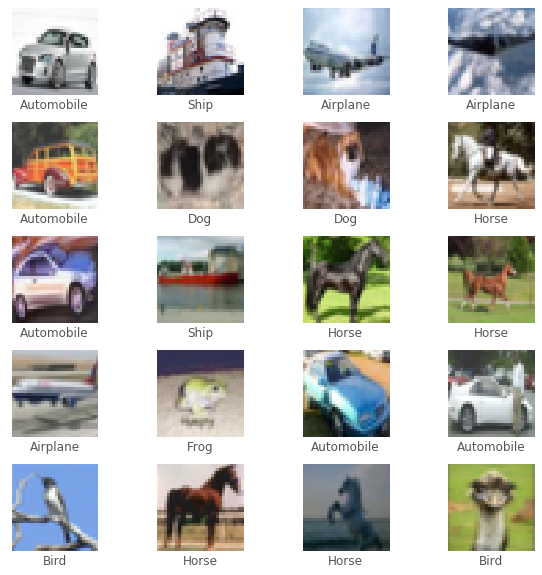

In [65]:
plt.figure(figsize=(10, 10))
plot_batch_images_labs(image_batch=train_img, label_batch=train_lab, batch_size=BATCH_SIZE)
plt.show()

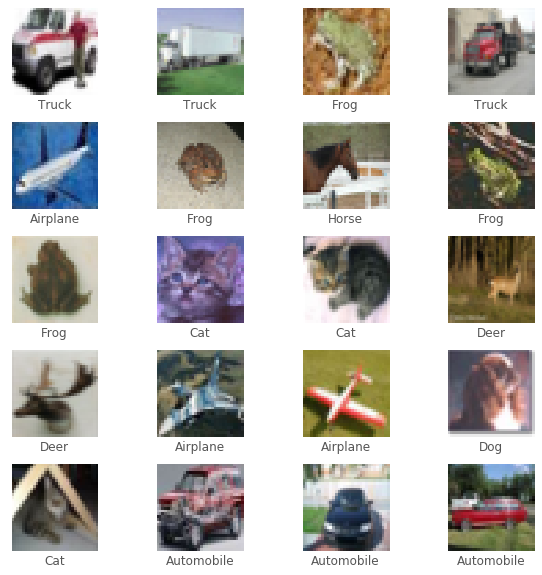

In [66]:
plt.figure(figsize=(10, 10))
plot_batch_images_labs(image_batch=valid_img, label_batch=valid_lab, batch_size=BATCH_SIZE)
plt.show()

In [0]:
tf.keras.backend.clear_session()

In [0]:
cifar10_v0_4_4_model = tf.keras.Sequential(layers=[

  tf.keras.layers.Conv2D(filters=5, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu, 
                         input_shape=(IMG_SIZE, IMG_SIZE, 3)), 
  tf.keras.layers.MaxPooling2D(pool_size=(1, 1), strides=1), 

  tf.keras.layers.Conv2D(filters=5, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(1, 2), strides=1), 

  tf.keras.layers.Conv2D(filters=6, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1), 

  tf.keras.layers.Conv2D(filters=8, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=(3, 3), 
                         padding='same', 
                         activation=tf.nn.relu), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), 

  tf.keras.layers.Flatten(), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.relu), 
  tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
])

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [0]:
cifar10_v0_4_4_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [71]:
cifar10_v0_4_4_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 5)         140       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 5)         230       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 31, 6)         276       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 30, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 30, 8)         4

In [72]:
history = cifar10_v0_4_4_model.fit(train_dataset, epochs=100, validation_data=valid_dataset)

Epoch 1/100
2250/2250 [==============================] - 40s 18ms/step - loss: 1.8582 - accuracy: 0.3021 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
2250/2250 [==============================] - 16s 7ms/step - loss: 1.5918 - accuracy: 0.4121 - val_loss: 1.5256 - val_accuracy: 0.4376
Epoch 3/100
2250/2250 [==============================] - 16s 7ms/step - loss: 1.4875 - accuracy: 0.4569 - val_loss: 1.5133 - val_accuracy: 0.4476
Epoch 4/100
2250/2250 [==============================] - 16s 7ms/step - loss: 1.4259 - accuracy: 0.4818 - val_loss: 1.4566 - val_accuracy: 0.4738
Epoch 5/100
2250/2250 [==============================] - 16s 7ms/step - loss: 1.3766 - accuracy: 0.5017 - val_loss: 1.4082 - val_accuracy: 0.4987
Epoch 6/100
2250/2250 [==============================] - 16s 7ms/step - loss: 1.3289 - accuracy: 0.5214 - val_loss: 1.3785 - val_accuracy: 0.5062
Epoch 7/100
2250/2250 [==============================] - 16s 7ms/step - loss: 1.2910 - accuracy: 0.5346 - val_loss:

In [0]:
data = {
    'train_acc' : history.history['accuracy'], 
    'train_loss' : history.history['loss'], 
    'val_acc' : history.history['val_accuracy'], 
    'val_loss' : history.history['val_loss']
}

history_df = pd.DataFrame(data=data, index=history.epoch)

In [74]:
display(history_df.head(10))
display(history_df.tail(10))

,train_acc,train_loss,val_acc,val_loss
0,0.302111,1.858157,0.374333,1.652090
1,0.412089,1.574717,0.437556,1.525594
2,0.456911,1.477486,0.447556,1.513270
3,0.481778,1.418289,0.473778,1.456644
4,0.501733,1.369952,0.498667,1.408178
5,0.521400,1.324063,0.506222,1.378519
6,0.534644,1.287193,0.523222,1.346410
7,0.548956,1.250947,0.549222,1.287864
8,0.566289,1.214375,0.554667,1.260788
9,0.576378,1.186581,0.559444,1.245777


,train_acc,train_loss,val_acc,val_loss
90,0.665244,0.948449,0.611444,1.111294
91,0.665556,0.947016,0.612333,1.104807
92,0.667178,0.946387,0.611667,1.109922
93,0.666822,0.946259,0.613222,1.102995
94,0.665956,0.946935,0.615000,1.110926
95,0.666667,0.946139,0.612556,1.114770
96,0.666689,0.945203,0.613778,1.113806
97,0.666444,0.944265,0.612222,1.113712
98,0.665422,0.944414,0.611111,1.119213
99,0.665822,0.942512,0.612889,1.113385


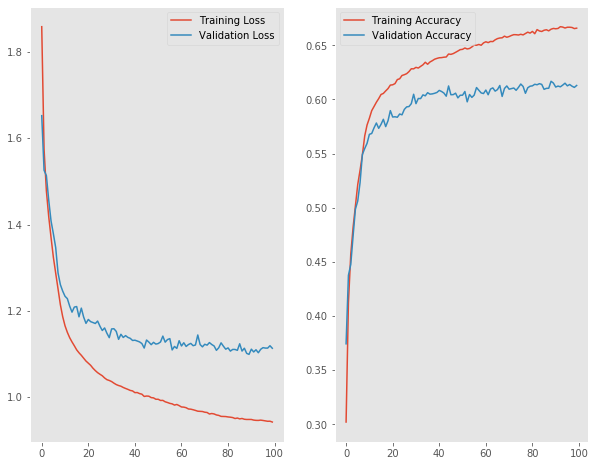

In [75]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(history_df.index, history_df['train_loss'], label="Training Loss")
plt.plot(history_df.index, history_df['val_loss'], label="Validation Loss")
plt.grid(False)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df.index, history_df['train_acc'], label="Training Accuracy")
plt.plot(history_df.index, history_df['val_acc'], label="Validation Accuracy")
plt.grid(False)
plt.legend()

plt.show()

In [0]:
def plot_test_images(index_i, prediction_batch_arr, true_labels, image_features):
  prediction_batch_arr = prediction_batch_arr[index_i]
  true_label = true_labels[index_i]
  image_features = image_features[index_i]

  predicted_label = np.argmax(prediction_batch_arr)

  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.imshow(image_features)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.xlabel("{} {}  ({})".format(class_names[predicted_label], 
                                  round(100*np.max(prediction_batch_arr), 2), 
                                  class_names[true_label]), color=color)

def plot_predicted_bars(index_i, prediction_batch_arr, true_labels):
  prediction_batch_arr = prediction_batch_arr[index_i]
  true_label = true_labels[index_i]

  this_plot = plt.bar(x=range(class_num), height=prediction_batch_arr, width=0.6)
  plt.grid(False)
  plt.xticks(range(class_num))
  plt.ylim([0, 1])

  this_plot[np.argmax(prediction_batch_arr)].set_color('red')
  this_plot[true_label].set_colot('green')

In [0]:
for test_image_batch, test_label_batch in test_dataset.take(count=1):
  break

In [78]:
test_image_batch.shape

TensorShape([20, 32, 32, 3])

In [79]:
test_label_batch.shape

TensorShape([20])

In [0]:
prediction_batch = cifar10_v0_4_4_model.predict(x=test_image_batch)

In [81]:
prediction_batch

array([[1.30097987e-03, 9.61145444e-04, 3.15396860e-03, 7.27271318e-01,
        1.44050675e-04, 2.53026783e-01, 2.44970340e-03, 3.12734046e-03,
        7.58631295e-03, 9.78320604e-04],
       [6.37143493e-01, 2.93918140e-02, 2.26530787e-02, 2.15526037e-02,
        6.79253861e-02, 5.12728747e-03, 3.23623675e-03, 4.91284125e-04,
        1.86649188e-01, 2.58297119e-02],
       [2.89776288e-02, 2.10399166e-01, 3.25690489e-04, 1.06918868e-02,
        4.27632872e-03, 2.35580257e-03, 7.40037765e-04, 1.06076093e-03,
        1.06251361e-02, 7.30547488e-01],
       [1.58407446e-02, 1.23875029e-02, 1.10614710e-01, 6.59944937e-02,
        5.50400279e-03, 8.07279348e-02, 1.06943650e-02, 6.94518268e-01,
        1.05018180e-03, 2.66786176e-03],
       [6.33229241e-02, 4.12268302e-04, 1.09444082e-01, 2.48587038e-03,
        7.82581747e-01, 2.72018090e-03, 3.40048224e-03, 3.50657627e-02,
        1.16576201e-04, 4.50128224e-04],
       [1.56894550e-02, 8.74562655e-04, 5.20918548e-01, 1.54181167e-01,
   

In [82]:
prediction_batch.shape

(20, 10)

In [0]:
prediction_ids = np.argmax(a=prediction_batch, axis=1)

In [84]:
prediction_ids

array([3, 0, 9, 7, 4, 2, 9, 9, 1, 3, 3, 1, 1, 2, 5, 8, 7, 9, 1, 7])

In [85]:
print(f"True labels : {test_label_batch}")
print(f"Predictions : {prediction_ids}")

True labels : [5 4 0 7 4 3 0 2 1 5 3 9 9 2 5 8 7 8 1 4]
Predictions : [3 0 9 7 4 2 9 9 1 3 3 1 1 2 5 8 7 9 1 7]
